<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{lit_colab_boris} -->

# Optimize ⚡ Pytorch-Lightning models with Weights & Biases

<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Optimize_Pytorch_Lightning_models_with_Weights_&_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Pytorch-Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) is a lightweight wrapper for organizing your PyTorch code and easily adding advanced features such as distributed training, 16-bit precision or gradient accumulation.

Coupled with [Weights & Biases integration](https://docs.wandb.com/library/integrations/lightning), you can quickly train and monitor models for full traceability and reproducibility with only 2 extra lines of code:

```python
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger()
```

W&B integration with Pytorch-Lightning can automatically:
* log your configuration parameters
* log your losses and metrics
* log gradients and parameter distributions
* log your model
* keep track of your code
* log your system metrics (GPU, CPU, memory, temperature, etc)

### 🛠️ Installation and set-up

We need to install the following libraries:
* [pytorch-lightning](https://pytorch-lightning.readthedocs.io/) to set up and train our models
* [wandb](https://docs.wandb.ai/) to instrument our training

In [ ]:
!pip install -qU pytorch-lightning wandb

In [ ]:
# For deterministic behavior with CUDA >= 10.2
# See https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

We make sure we're logged into W&B so that our experiments can be associated with our account.

In [ ]:
import wandb
wandb.login()

*Note*: in a terminal we would just call `wandb login` for initial set-up.

## 💡 Configuration tips

W&B integration with Pytorch-Lightning can be configured to add extra functionalities through `WandbLogger`:

* logging of models: use `log_model='all'` to upload every new checkpoint during training or `log_model=True` to upload them at the end of training
* log histograms of gradients and parameters: use `WandbLogger.watch(model)` to log gradients and `WandbLogger.watch(model, log='all')` to also log parameter histograms
* log hyperparameters: call `self.save_hyperparameters()` within `LightningModule.__init__()`
* set custom run names with `name='my_run_name'`
* organize runs by project with `WandbLogger(project='my_project')`
* log custom objects (images, audio, video, molecules…) with `WandbLogger.log_text`, `WandbLogger.log_image` and `WandbLogger.log_table`

For more details refer to [W&B + Pytorch-Lightning integration documentation](https://docs.wandb.ai/integrations/lightning) and [Pytorch-Lightning WandbLogger documentation](https://pytorch-lightning.readthedocs.io/en/stable/extensions/generated/pytorch_lightning.loggers.WandbLogger.html).

## 🔬 Advanced usage

Let's build our own logic for a customized training.

### 🔍 Reproducibility

We ensure our experiments will be fully reproducible by setting seeds in every random generator through `seed_everything`.

In [ ]:
from pytorch_lightning import seed_everything
seed_everything(42)

### ✏️ Setting up the data pipeline

Data pipelines can be created with:
* Vanilla Pytorch `DataLoaders`
* Pytorch Lightning `DataModules`

`DataModules` allow for additional automated optimization such as workload distribution between CPU & GPU. Using `DataModules` is recommended whenever possible!

A `DataModule` is defined with:
* `prepare_data` (optional) which is called only once and on 1 GPU
* `setup`, which is called on each GPU and accepts `stage` to define if we are at `fit` (train + validate), `validate`, `test`  or `predict` step
* `train_dataloader`, `val_dataloader` and `test_dataloader` to load each dataset

In [ ]:
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST  # dataset
from torchvision import transforms      # computer vision transforms

class MNIST_DataModule(LightningDataModule):

    def __init__(self, data_dir='./', batch_size=256):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

    def prepare_data(self):
        '''called only once and on 1 GPU'''
        # download data (train/val and test sets)
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        '''called on each GPU separately - stage defines if we are at fit, validate, test or predict step'''
        # we set up only relevant datasets when stage is specified (automatically set by Lightning)
        if stage in [None, 'fit', 'validate']:
            mnist_train = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_train, [55000, 5000])
        if stage in [None, 'test']:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        mnist_train = DataLoader(self.mnist_train, batch_size=self.batch_size)
        return mnist_train

    def val_dataloader(self):
        mnist_val = DataLoader(self.mnist_val, batch_size=self.batch_size)
        return mnist_val

    def test_dataloader(self):
        mnist_test = DataLoader(self.mnist_test, batch_size=self.batch_size)
        return mnist_test

The data pipeline is now ready!

In [ ]:
mnist = MNIST_DataModule()

### ✨ Defining a model

In Pytorch-Lightning, models are built with `LightningModule`, equivalent to `torch.nn.Module` but with added functionality to simplify training.

Models are defined with:
* `__init__` for model parameters
* `forward` for inference
* `training_step` (+ optionnally `validation_step` and `test_step`) returns a loss from a single batch
* `configure_optimizers` defines the training optimizer

Additional methods can be defined such as:
* `training_step_end` and `training_epoch_end` for more complex loops
* other custom hooks for more flexibility

**Tips**:
* call `self.save_hyperparameters()` in `__init__` to automatically log your hyperparameters to W&B
* set your learning rate property as `lr` or `learning_rate` to take advantage of the learning rate finder

In [ ]:
import torch
from torch.nn import Linear, CrossEntropyLoss, functional as F
from torch.optim import Adam
from torchmetrics.functional import accuracy
from pytorch_lightning import LightningModule

class MNIST_LitModule(LightningModule):

    def __init__(self, n_classes=10, n_layer_1=128, n_layer_2=256, lr=1e-3):
        '''method used to define our model parameters'''
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = Linear(28 * 28, n_layer_1)
        self.layer_2 = Linear(n_layer_1, n_layer_2)
        self.layer_3 = Linear(n_layer_2, n_classes)

        # loss
        self.loss = CrossEntropyLoss()

        # optimizer parameters
        self.lr = lr

        # save hyper-parameters to self.hparams (auto-logged by W&B)
        self.save_hyperparameters()

    def forward(self, x):
        '''method used for inference input -> output'''

        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)

        # let's do 3 x (linear + relu)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)

        return x

    def training_step(self, batch, batch_idx):
        '''needs to return a loss from a single batch'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)

        return loss

    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)

        # Let's return preds to use it in a custom callback
        return preds

    def test_step(self, batch, batch_idx):
        '''used for logging metrics'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)
    
    def configure_optimizers(self):
        '''defines model optimizer'''
        return Adam(self.parameters(), lr=self.lr)
    
    def _get_preds_loss_accuracy(self, batch):
        '''convenience function since train/valid/test steps are similar'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, y)
        acc = accuracy(preds, y)
        return preds, loss, acc

*Note:* We return `preds` in `validation_step` for future access in a custom callback that will automatically log sample predictions.

Our model is now ready!

In [ ]:
model = MNIST_LitModule(n_layer_1=128, n_layer_2=256)

### ⚙️ Using callbacks to log sample predictions

Pytorch Lightning is extensible through its callback system.

We create a custom callback to automatically log sample predictions during validation.

`WandbLogger` provides convenient media logging functions:
* `WandbLogger.log_text` for text data
* `WandbLogger.log_image` for images
* `WandbLogger.log_table` for [W&B Tables](https://docs.wandb.ai/guides/data-vis).

In [ ]:
from pytorch_lightning.callbacks import Callback
 
class LogPredictionsCallback(Callback):
    
    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        """Called when the validation batch ends."""
 
        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case
        
        # Let's log 20 sample image predictions from first batch
        if batch_idx == 0:
            n = 20
            x, y = batch
            images = [img for img in x[:n]]
            captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' for y_i, y_pred in zip(y[:n], outputs[:n])]
            # Option 1: log images with `WandbLogger.log_image`
            wandb_logger.log_image(key='sample_images', images=images, caption=captions)
            # Option 2: log predictions as a Table
            columns = ['image', 'ground truth', 'prediction']
            data = [[wandb.Image(x_i), y_i, y_pred] for x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
            wandb_logger.log_table(key='sample_table', columns=columns, data=data)

*Notes:*

* we could log our predictions in `LightningModule.validation_step`
* we could directly log with `wandb.log({dict}` or `trainer.logger.experiment.log({dict})`

### 🖍️ Setting up the model

Pytorch Lightning includes a `Trainer` class for interacting with our model.

In [ ]:
from pytorch_lightning import Trainer

We verify that we initially have an accuracy of about 10% (random predictions over 10 classes). 

In [ ]:
Trainer(gpus=1).test(model, datamodule=mnist)

First let's take advantage of the learning rate finder.

In [ ]:
trainer = Trainer(auto_lr_find=True)
trainer.tune(model, datamodule=mnist)

We can check that the learning rate has been modified.

In [ ]:
model.lr

### 💾 Configuring model saving

By default, the `Trainer` automatically saves a checkpoint from the last training epoch.

We can customize model saving through `ModelCheckpoint`. Let's save a new checkpoint only when validation accuracy improves.

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')

*Note:* use `ModelCheckpoint(monitor='val_accuracy', mode='max', save_top_k=3)` if you want to keep the 3 best checkpoints.

### 📊 Tracking the experiment

`WandbLogger` let us automatically track our experiment with Weights & Biases (see [documentation](https://docs.wandb.ai/integrations/lightning) for custom options).

In [ ]:
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project='MNIST', # group runs in "MNIST" project
                           log_model='all') # log all new checkpoints during training

We use the `WandbLogger.watch` method to automatically log gradients and model topology.

In [ ]:
wandb_logger.watch(model)

*Note:* we can also directly call `wandb.watch(model)`

### 🎉 Training the model

The `Trainer` class let us easily train a model and is very flexible.

In [ ]:
trainer = Trainer(
    logger=wandb_logger,                    # W&B integration
    callbacks=[checkpoint_callback,         # our model checkpoint callback
               LogPredictionsCallback()],   # logging of sample predictions
    gpus=-1,                                # use all available GPU's
    max_epochs=5,                           # number of epochs
    precision=16,                           # train in half precision
    deterministic=True)                     # for reproducibility

Once we're ready to train, we just call the `fit` method.

In [ ]:
trainer.fit(model, datamodule=mnist)

We can monitor losses, metrics, gradients, parameters and sample predictions as the model trains.

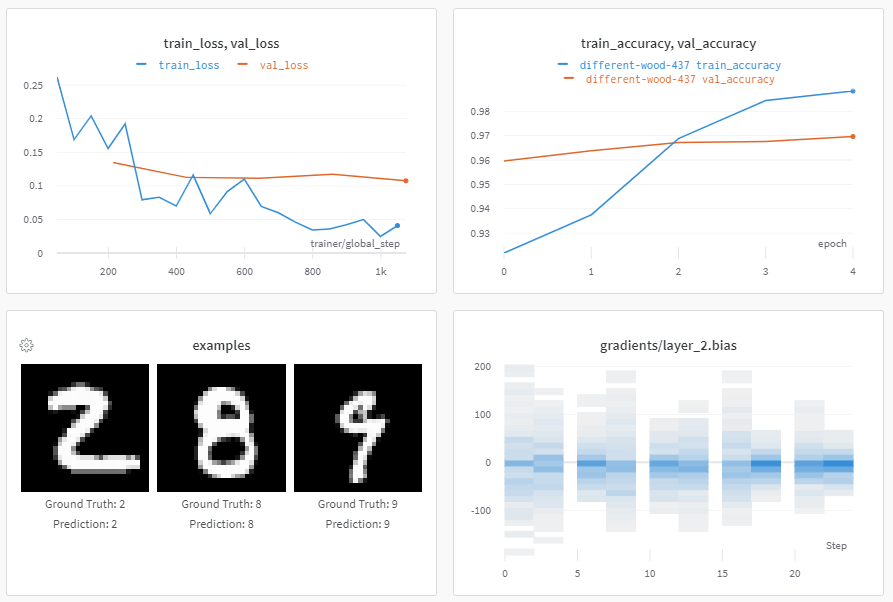

Logging trough [W&B Tables](https://docs.wandb.ai/guides/data-vis) allows powerful queries, filtering, grouping and comparisons.

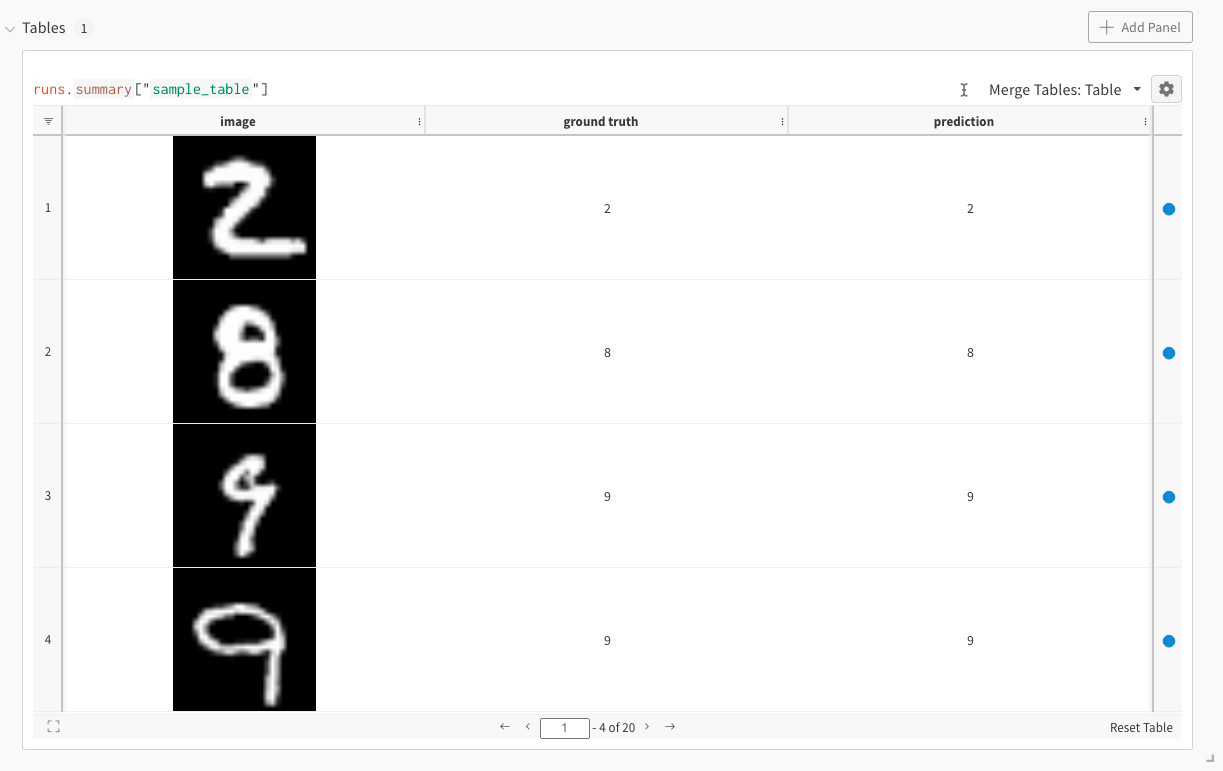

Our model checkpoints are logged and versioned with their performance as metadata.

Version aliases "latest" and "best" are created automatically. The alias "best" is defined by our `ModelCheckpoint` (same as "latest" when `ModelCheckpoint.monitor` is not defined).

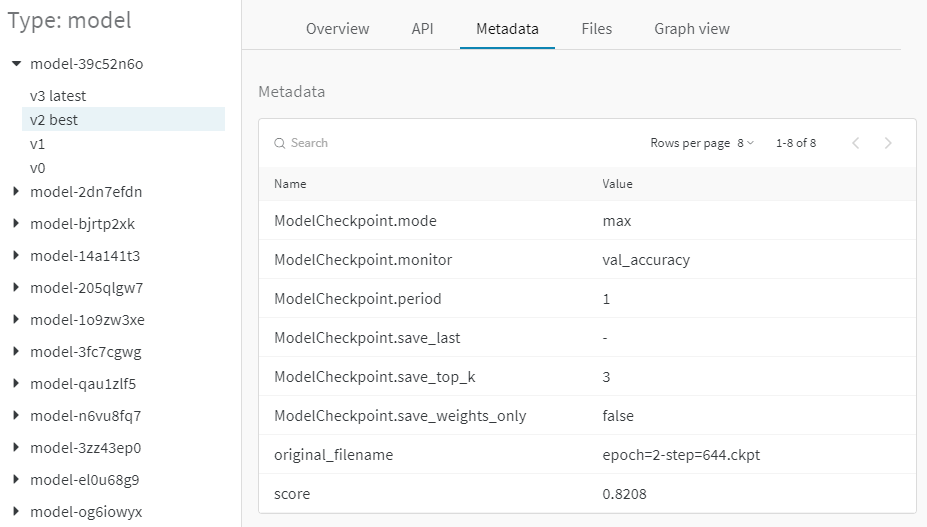

We evaluate our final metrics on the test dataset with the `test` method.

In [ ]:
trainer.test(model, datamodule=mnist)

We keep track of a few run parameters for future reference of our artifacts.

In [ ]:
run_id = trainer.logger.experiment.id
project = trainer.logger.experiment.project
entity = trainer.logger.experiment.entity

When we want to close our W&B run, we call `wandb.finish()` (mainly useful in notebooks, called automatically in scripts).

In [ ]:
wandb.finish()

After a few runs with different hyper-parameters, we can have a better idea of how to optimize the model.

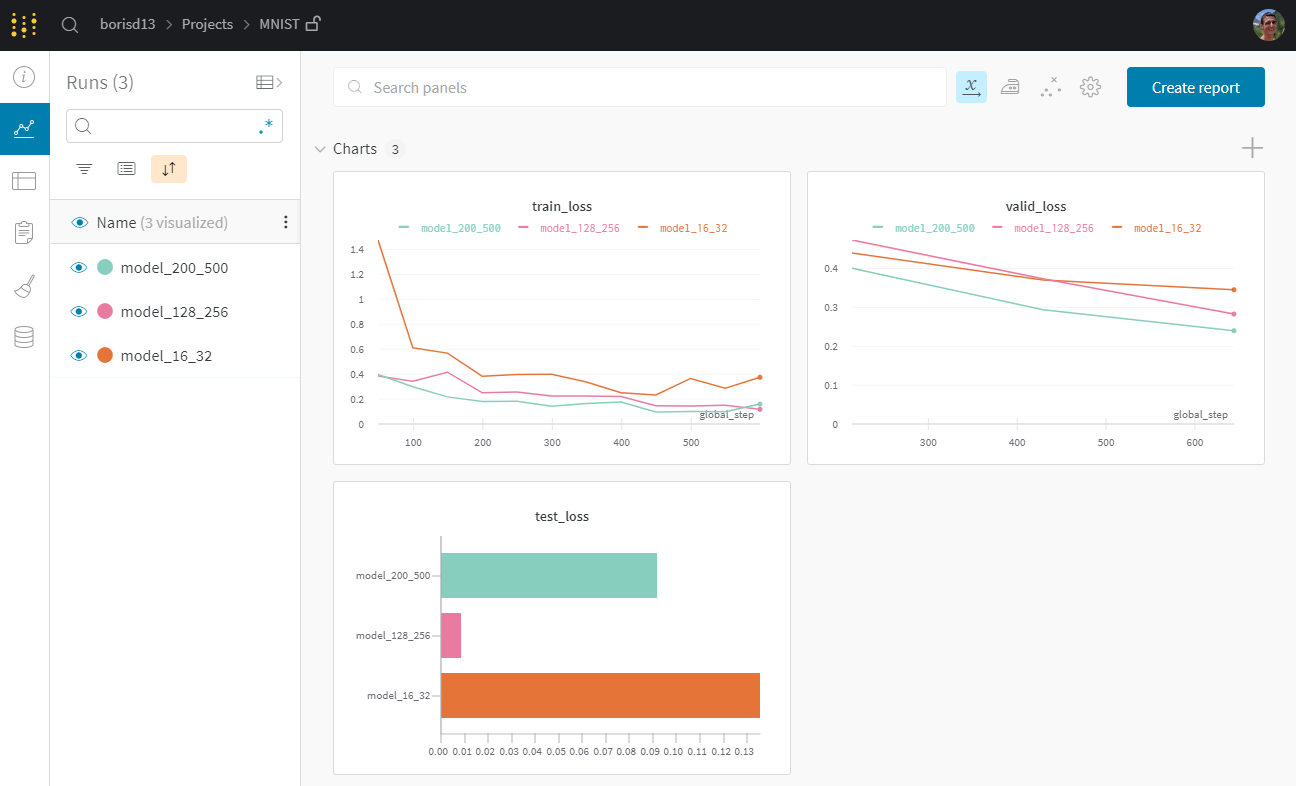

### 📖 Loading a logged model

In subsequent experiments, we can easily choose a model that was logged previously.

Models logged by `WandbLogger` are named `'USER/PROJECT/MODEL-RUN_ID:VERSION'`.

The version can also be replaced with aliases such as `best` or `latest`.

For example, we can easily access the "best" checkpoint from the previous run.

In [ ]:
checkpoint_reference = f'{entity}/{project}/model-{run_id}:best'
checkpoint_reference

We can also find download instructions for any artifact on our dashboard.

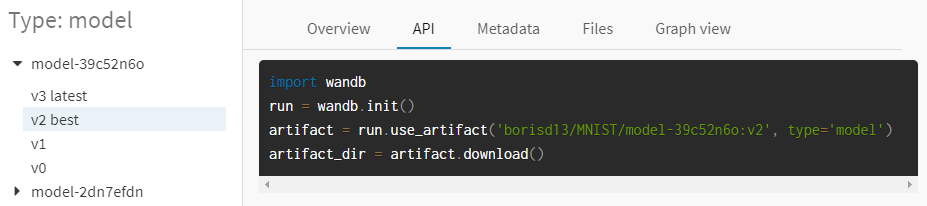

Files are downloaded and cached with `artifact.download()`.

In [ ]:
run = wandb.init(project='MNIST')
artifact = run.use_artifact(checkpoint_reference, type='model')
artifact_dir = artifact.download()
artifact_dir

The artifact folder should now contain our checkpoint.

In [ ]:
from pathlib import Path
list(Path(artifact_dir).glob('*'))

We can use our `LightningModule` to restore the model from its checkpoint.

In [ ]:
model = MNIST_LitModule.load_from_checkpoint(Path(artifact_dir)/'model.ckpt')

Finally we verify the accuracy of the model on the test set.

In [ ]:
Trainer().test(model, datamodule=mnist)

When we're done with our new experiment, we can just close it.

In [ ]:
wandb.finish()

W&B tracks the relationship between every artifact created.

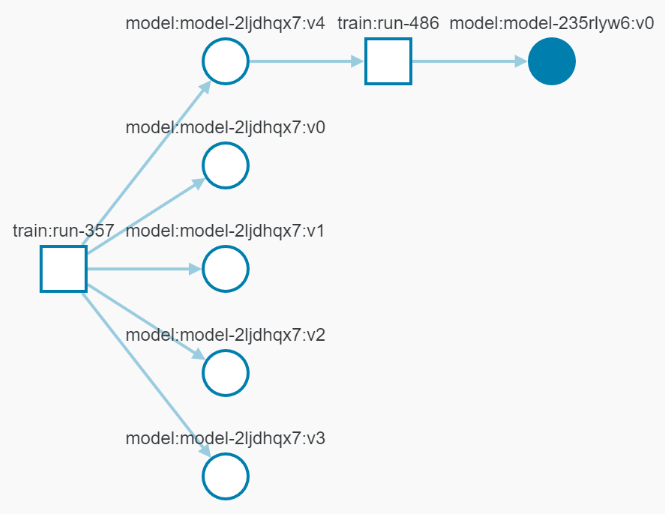

W&B artifacts are extremely powerful and very flexible.

Refer to [the documentation](https://docs.wandb.ai/artifacts) for custom workflows and best practices for model and data versioning.

## 🎊 Hyperparameter optimization with W&B sweeps

So far, we chose our hyper-parameters arbitrarily.

We can automate hyperparameter search with [W&B sweeps](https://docs.wandb.com/sweeps).

### 📎 Defining sweep configuration

Sweeps can be defined in multiple ways:
* with a YAML file - best for distributed sweeps and runs from command line
* with a Python object - best for notebooks


The main items to be defined in a sweep are:
*   **Metric** – This is the metric the sweeps are attempting to optimize. Metrics can take a `name` (this metric should be logged by your training script) and a `goal` (maximize or minimize). 
*   **Search Strategy** – We support several different search strategies with sweeps – `grid`, `random`, `bayes`.
*   **Stopping Criteria** – The strategy for determining when to kill off poorly peforming runs, and try more combinations faster. We offer several custom scheduling algorithms like [HyperBand](https://arxiv.org/pdf/1603.06560.pdf) and Envelope.
*   **Parameters** – A dictionary containing the hyperparameter names, and discreet values, max and min values or distributions from which to pull their values to sweep over.

*Note: you can also use other search libraries such as [Ray-Tune](https://docs.wandb.com/sweeps/ray-tune) or even [create your own search algorithm](https://docs.wandb.com/sweeps/python-api#run-a-local-controller)*

Here we just use a Python object. Refer to the [sweep configuration documentation](https://docs.wandb.com/sweeps/configuration) if you want to define more parameters.

In [ ]:
sweep_config = {
  "method": "random",   # Random search
  "metric": {           # We want to maximize val_accuracy
      "name": "val_accuracy",
      "goal": "maximize"
  },
  "parameters": {
        "n_layer_1": {
            # Choose from pre-defined values
            "values": [32, 64, 128, 256, 512]
        },
        "n_layer_2": {
            # Choose from pre-defined values
            "values": [32, 64, 128, 256, 512, 1024]
        },
        "lr": {
            # log uniform distribution between exp(min) and exp(max)
            "distribution": "log_uniform",
            "min": -9.21,   # exp(-9.21) = 1e-4
            "max": -4.61    # exp(-4.61) = 1e-2
        }
    }
}

We create a sweep id based on our configuration.

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="MNIST")

### 🎩 Running an agent

We now just need to run an agent against the sweep configuration. Sweeps can be run in multiple ways:
* through a command line with `wandb sweep my_sweep_config.yaml`
* directly within a script/notebook with the [Python sweep API](https://docs.wandb.com/sweeps/python-api)

To use the Python sweep API, we define a function that the agent will run, refering to sweep parameters with `wandb.config.my_param`.

In [ ]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger = WandbLogger(log_model=True)  # log final model

    # setup data
    mnist = MNIST_DataModule()

    # setup model - note how we refer to sweep parameters with wandb.config
    model = MNIST_LitModule(
        n_layer_1=wandb.config.n_layer_1,
        n_layer_2=wandb.config.n_layer_2,
        lr=wandb.config.lr
    )

    # setup Trainer
    trainer = Trainer(
        logger=wandb_logger,    # W&B integration
        gpus=-1,                # use all GPU's
        max_epochs=3            # number of epochs
        )

    # train
    trainer.fit(model, datamodule=mnist)

Finally we just run an agent that will iterate over the sweep parameters with specified search method.

In [ ]:
wandb.agent(sweep_id, function=sweep_iteration)

You can now see in real time your parameters being optimized.

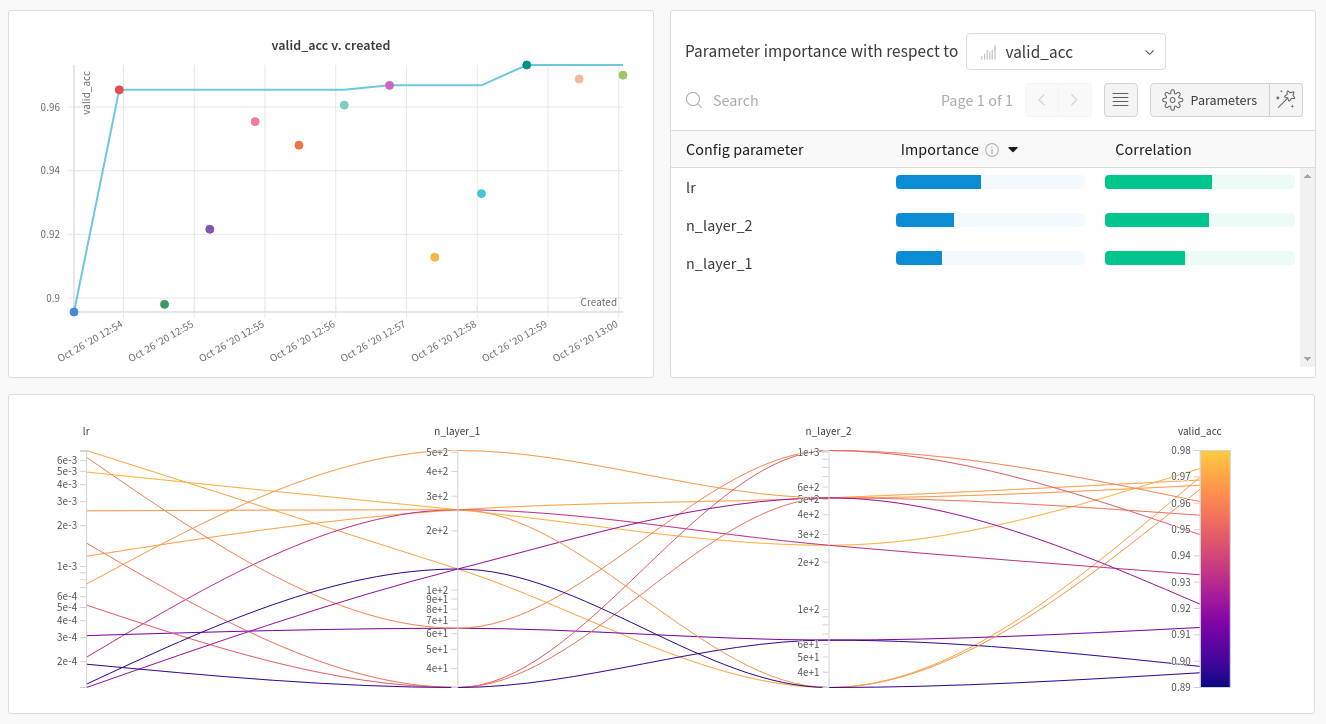

## 📚 Resources

* [Pytorch Lightning and W&B integration documentation](https://docs.wandb.ai/integrations/lightning) contains a few tips for taking most advantage of W&B
* [Pytorch Lightning documentation](https://pytorch-lightning.readthedocs.io/en/stable/) is extremely thorough and full of examples

## ❓ Questions about W&B

If you have any questions about using W&B to track your model performance and predictions, please reach out to the [slack community](http://bit.ly/wandb-forum).